# Converting Between Image Types

**Goal:** Demonstrate how to convert between various kinds of image data structures.

**Types covered:**
- Python:
    - numpy array
    - xarray
- Java
    - `RandomAccessibleInterval` and `IterableInterval` (ImgLib2)
    - `Dataset` (ImageJ2)
    - `ImagePlus` (ImageJ1)

In [1]:
import imagej
ij = imagej.init('net.imagej:imagej:2.1.0')

## Starting from Python

<class 'numpy.ndarray'>
205


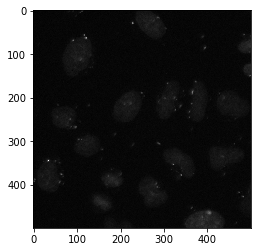

In [2]:
from skimage import io
arr = io.imread('example_images/example_tif.tif')
x = 7; y = 8 # a sample of interest
print(type(arr))
print(arr[x,y])
ij.py.show(arr, cmap = 'gray')

### numpy ➡ RandomAccessibleInterval

In [3]:
rai = ij.py.to_java(arr)
print(type(rai))
from jpype import JArray, JLong
JLongArray = JArray(JLong)
pos = JLongArray([y, x]) # NB: Reverse order from Python!
print(rai.getAt(pos))

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>
205


### numpy ➡ Dataset

In [4]:
dataset_from_arr = ij.py.to_dataset(arr)
print(type(dataset_from_arr))
print(dataset_from_arr.getAt(pos))

<java class 'net.imagej.DefaultDataset'>
205


### RandomAccessibleInterval ➡ Dataset

In [5]:
dataset_from_rai = ij.py.to_dataset(rai)
print(type(dataset_from_rai))
print(dataset_from_rai.getAt(pos))

<java class 'net.imagej.DefaultDataset'>
205


### Dataset ➡ ImagePlus

In [6]:
imp = ij.legacy.getImageMap().registerDataset(dataset_from_arr)
print(type(imp))
print(imp.getProcessor().getf(y, x))

<java class 'ij.ImagePlus'>
205.0


### Do changes in Python affect Java?

In [7]:
def print_value(x, y):
    print(f'arr: {arr[x,y]}')
    print(f'rai: {rai.getAt(pos)}')
    print(f'dataset_from_arr: {dataset_from_arr.getAt(pos)}')
    print(f'dataset_from_rai: {dataset_from_rai.getAt(pos)}')
    print(f'imp: {imp.getProcessor().getf(y, x)}')

arr[x,y] = 123
print_value(x, y)

arr: 123
rai: 123
dataset_from_arr: 123
dataset_from_rai: 123
imp: 205.0


### What happens if ImageJ2 data changes?

In [8]:
### Do changes in ImageJ2 affect Python?
def set_pixel(rai, x, y, value):
    ra = rai.randomAccess()
    # NB: Y then X!
    ra.setPosition(y, 0)
    ra.setPosition(x, 1)
    ra.get().setReal(value)

print('--> changing rai to 11')
set_pixel(rai, x, y, 11)
print_value(x, y)
print('--> changing dataset_from_arr to 22')
set_pixel(dataset_from_arr, x, y, 22)
print_value(x, y)
print('--> changing dataset_from_rai to 33')
set_pixel(dataset_from_rai, x, y, 33)
print_value(x, y)

--> changing rai to 11
arr: 11
rai: 11
dataset_from_arr: 11
dataset_from_rai: 11
imp: 205.0
--> changing dataset_from_arr to 22
arr: 22
rai: 22
dataset_from_arr: 22
dataset_from_rai: 22
imp: 205.0
--> changing dataset_from_rai to 33
arr: 33
rai: 33
dataset_from_arr: 33
dataset_from_rai: 33
imp: 205.0


### What happens if ImageJ1 data changes?

In [9]:
print('--> Changing imp to 44')
imp.getProcessor().setf(y, x, 44) # NB: Y then X!
print_value(x, y)
print('--> Synchronizing imp back to ImageJ2')
ij.py.synchronize_ij1_to_ij2(imp)
print_value(x, y)

--> Changing imp to 44
arr: 33
rai: 33
dataset_from_arr: 33
dataset_from_rai: 33
imp: 44.0
--> Synchronizing imp back to ImageJ2
arr: 44
rai: 44
dataset_from_arr: 44
dataset_from_rai: 44
imp: 44.0
